# PyGeM
# Tutorial: Mesh deformation
In this tutorial we're going to use several tools from **PyGeM** in order to interpolate a *new* mesh after the deformation of the obstacle around which the original mesh is arranged. As you can see from the image below, the *old* mesh usally becomes unusable after the deformation:

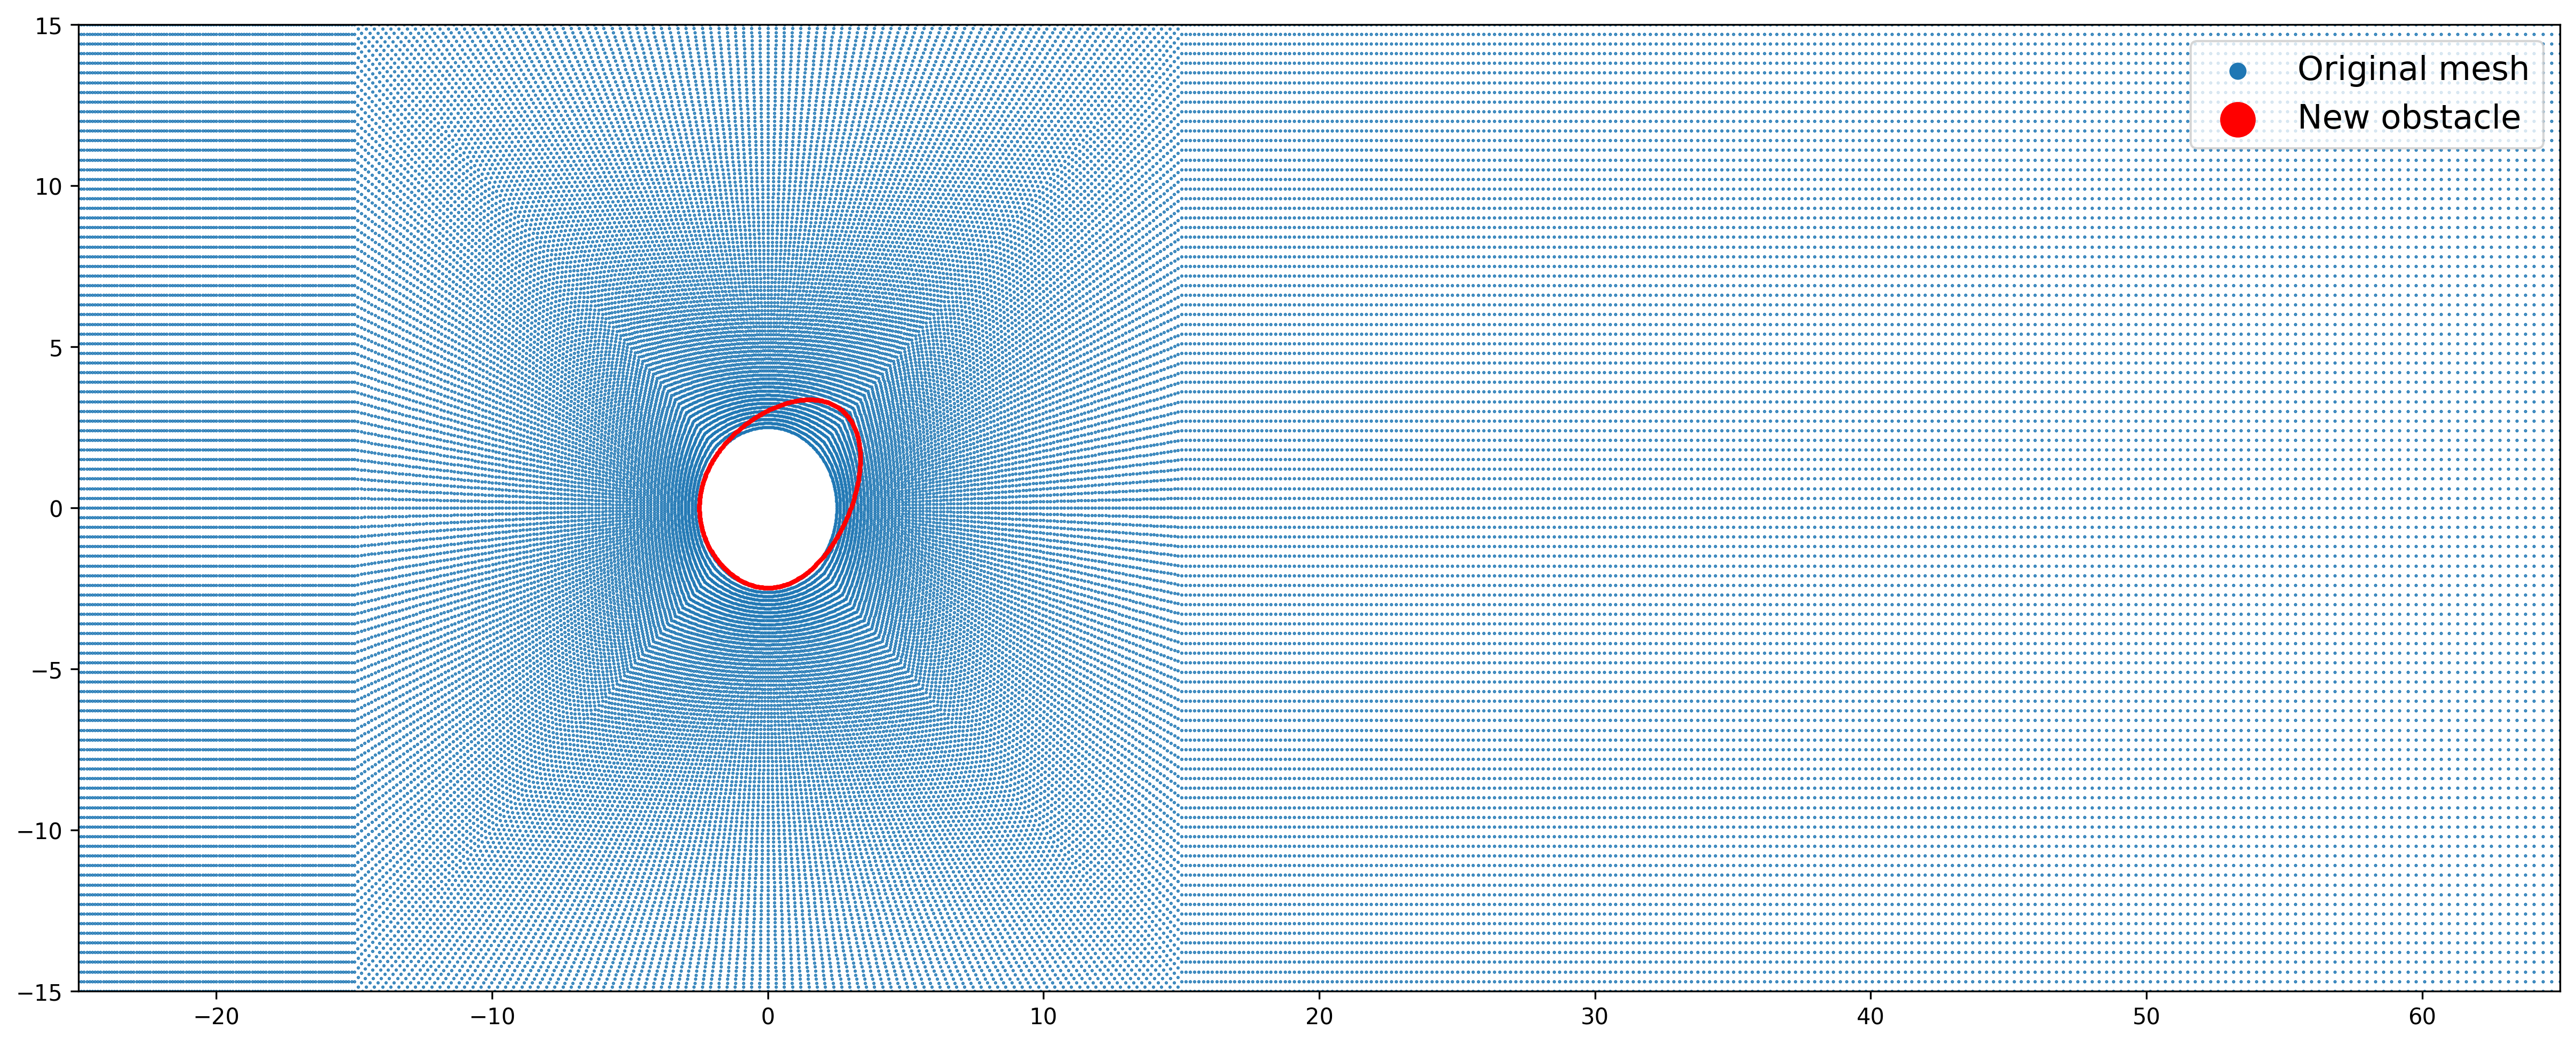

In [1]:
from IPython.display import Image
Image(filename='unusable_original_mesh.png') 

However, using an interpolation-based technique we're able to approximate a reasonable mesh which can be used with the deformed obstacle.

We're going to perform the deformation using the *free-form deformation* method. This method is implemented and documented in the `pygem.ffd` module; moreover, we're going to use the module `pygem.rbf` for the interpolation of the points which compose the new mesh after the deformation, and the package `ofpp` (GitHub [repository](https://github.com/xu-xianghua/ofpp)) for the initial parsing of the files which contain information about the *old* mesh.

First of all, we import all the libraries which we're going to use.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# mesh parsing
import openfoamparser as Ofpp
# interpolator
from scipy.interpolate import Rbf
# deformation
from pygem import FFD, RBF

Then we define the auxiliary function `scatter3d` which we're going to use often to plot several objects as lists of 3D points:

In [3]:
def scatter3d(arr, figsize=(8,8), s=10, draw=True, ax=None, alpha=1, labels=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(projection='3d')
        
    for idx,a in enumerate(arr):
        if labels is not None:
            ax.scatter(*a.T, s=s, alpha=alpha, label=labels[idx])
        else:
            ax.scatter(*a.T, s=s, alpha=alpha)
        
    if draw:
        if labels is not None:
            plt.legend()
        plt.show()
    else:
        return ax

## Extraction of mesh points
We use OFPP to extract points from an OpenFOAM mesh. First of all we employ the method `FoamMesh` to create a `mesh` object which contains all the relevant information. Then we define some convenient functions to extract data which we're interested in (like the obstacle, or walls). Finally we show how those functions work with a short example.

In [4]:
mesh_path = '.'
# we load the OpenFOAM mesh
mesh = Ofpp.FoamMesh(mesh_path)

We define the following auxiliary functions:
+ `extract_boundary_faces`: returns a 3D array which consists in a list of faces, represented by lists of points, which compose a given obstacle;

In [5]:
def extract_boundary_faces(mesh, key):
    obstacle = mesh.boundary[key]
    obstacle_faces = np.array(mesh.faces[obstacle.start:obstacle.start+obstacle.num])
    obstacle_points = np.apply_along_axis(lambda v: np.array([mesh.points[x] for x in v]), 
                                          axis=1, arr=obstacle_faces)
    return obstacle_points

+ `extract_boundary_points`: returns a 2D array which consists in a list of points which compose a given obstacle.

In [6]:
def extract_boundary_points(mesh, key):
    l = []
    for v in extract_boundary_faces(mesh, key):
        l.extend(v)
    return np.array(l)

+ `walls_points`: returns a 2D array which consists in a list of points which compose all the "walls" in the mesh (top, bottom, inlet, outlet). The indexing is the same of the output of `extract_boundary_points`.

In [7]:
def walls_points(mesh):
    keys = [b'inlet', b'outlet', b'top', b'bottom']
    return np.concatenate([extract_boundary_points(mesh, k) for k in keys])

We then plot the obstacle and the walls for the mesh.

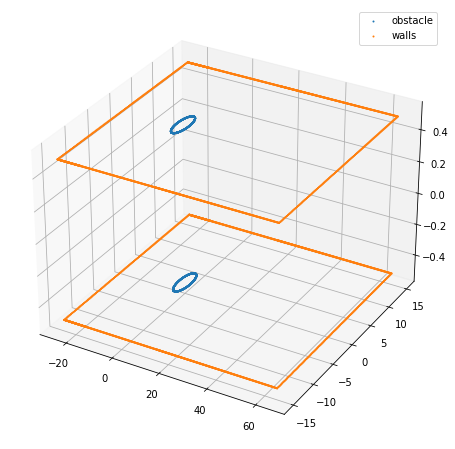

In [8]:
obstacle = extract_boundary_points(mesh, b'obstacle')
scatter3d([obstacle, walls_points(mesh)], s=1, labels=['obstacle', 'walls'])

As you can see our geometry is made of two faces, one at `z=0.5` and the other at `z=-0.5`.

## Deformation
We use the `FFD` deformation from [PyGem](https://github.com/mathLab/PyGeM) (for a reference check [this](http://mathlab.github.io/PyGeM/tutorial-1-ffd.html) tutorial) to deform the original obstacle (the upper and lower faces of a cylinder). First of all we define a `transform` function which provides the deformation.

In [9]:
def transform(vec):
    ffd = FFD([2, 2, 2])

    ffd.box_origin = np.array([-2.6,-2.6,-1.1])
    ffd.box_length = np.array([5.2,5.2,2.2])

    ffd.array_mu_x[1, 1, 0] = 0.3
    ffd.array_mu_y[1, 1, 0] = 0.3

    ffd.array_mu_x[1, 1, 1] = 0.3
    ffd.array_mu_y[1, 1, 1] = 0.3
    
    return ffd(vec)

We then operate the deformation and plot the result, against the old version of the obstacle.

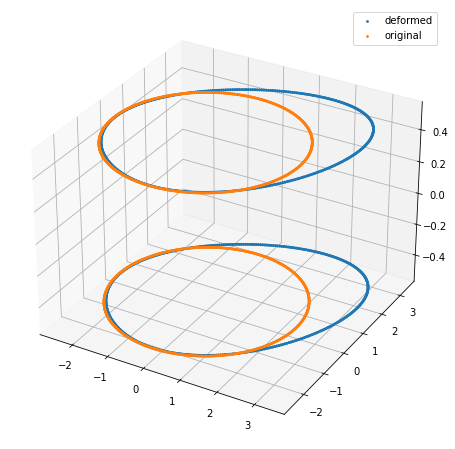

In [10]:
scatter3d([transform(obstacle), obstacle], s=3, labels=['deformed', 'original'])

## Interpolation
We intend to use an interpolator to determine the new position of the points which compose the mesh. Therefore we define the function `train_interpolators`, which trains the `RBF` interpolator using the points that represent the new position of the deformed obstacle against the old position, and the fact that walls **do not move** from their old position (this condition is considered in order to prevent the mesh from escaping the rectangle).

In [11]:
def train_interpolators(old_walls, old_obstacle_points, new_obstacle_points, **kwargs):
    train_points = np.vstack([old_walls, old_obstacle_points])
    train_values = np.vstack([old_walls, new_obstacle_points])
    
    train_points, uindexes = np.unique(train_points, return_index=True, axis=0)
    train_values = train_values[uindexes]
    
    return RBF(original_control_points = train_points, deformed_control_points = train_values, radius=5)

## New mesh
At this point we can use the ingredients we prepared in the last sections to interpolate the new mesh after the deformation of the obstacle. First of all, we train the interpolators (function `train_interpolators`) using the functions `wall_points` (which returns the position of the walls, which as the reader may remembr **do not move**), and the new points which compose the obstacle after the deformation (function `transform`). We also show the control points considered during the interpolation with `RBF` (*original* and *deformed*).

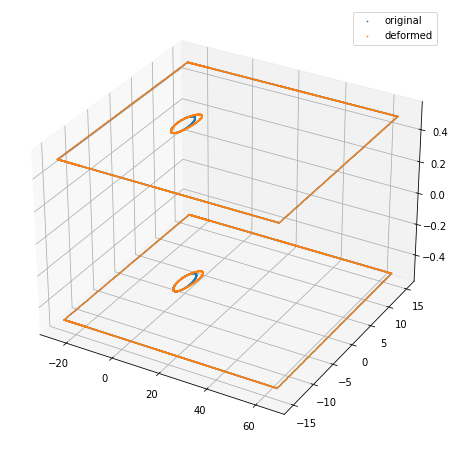

In [12]:
interp = train_interpolators(walls_points(mesh), obstacle, transform(obstacle))
scatter3d([interp.original_control_points, interp.deformed_control_points], s=0.5, labels=['original', 'deformed'])

We then use the interpolators to determine the new position of the points which compose the mesh. This is a resource-intensive computation and may slow down the device on which you're running this notebook.

In [13]:
new_mesh_points = interp(mesh.points)

The last thing to do is to plot the mesh after the interpolation. In order to visualize the results we prefer a 2D scatter plot of the upper part of the mesh (`z=0.5`). Therefore we define the auxiliary function `upper_layer` which extracts the points at `z=0.5` from the given list of points.

In [16]:
def upper_layer(*arrs):
    points = arrs[0]
    idxes = points[:,2] > 0
    
    if len(arrs) > 1:
        return (arr[idxes] for arr in arrs)
    else:
        return points[idxes]

We can now plot the interpolated mesh, with the *deformed* and *original* obstacle.

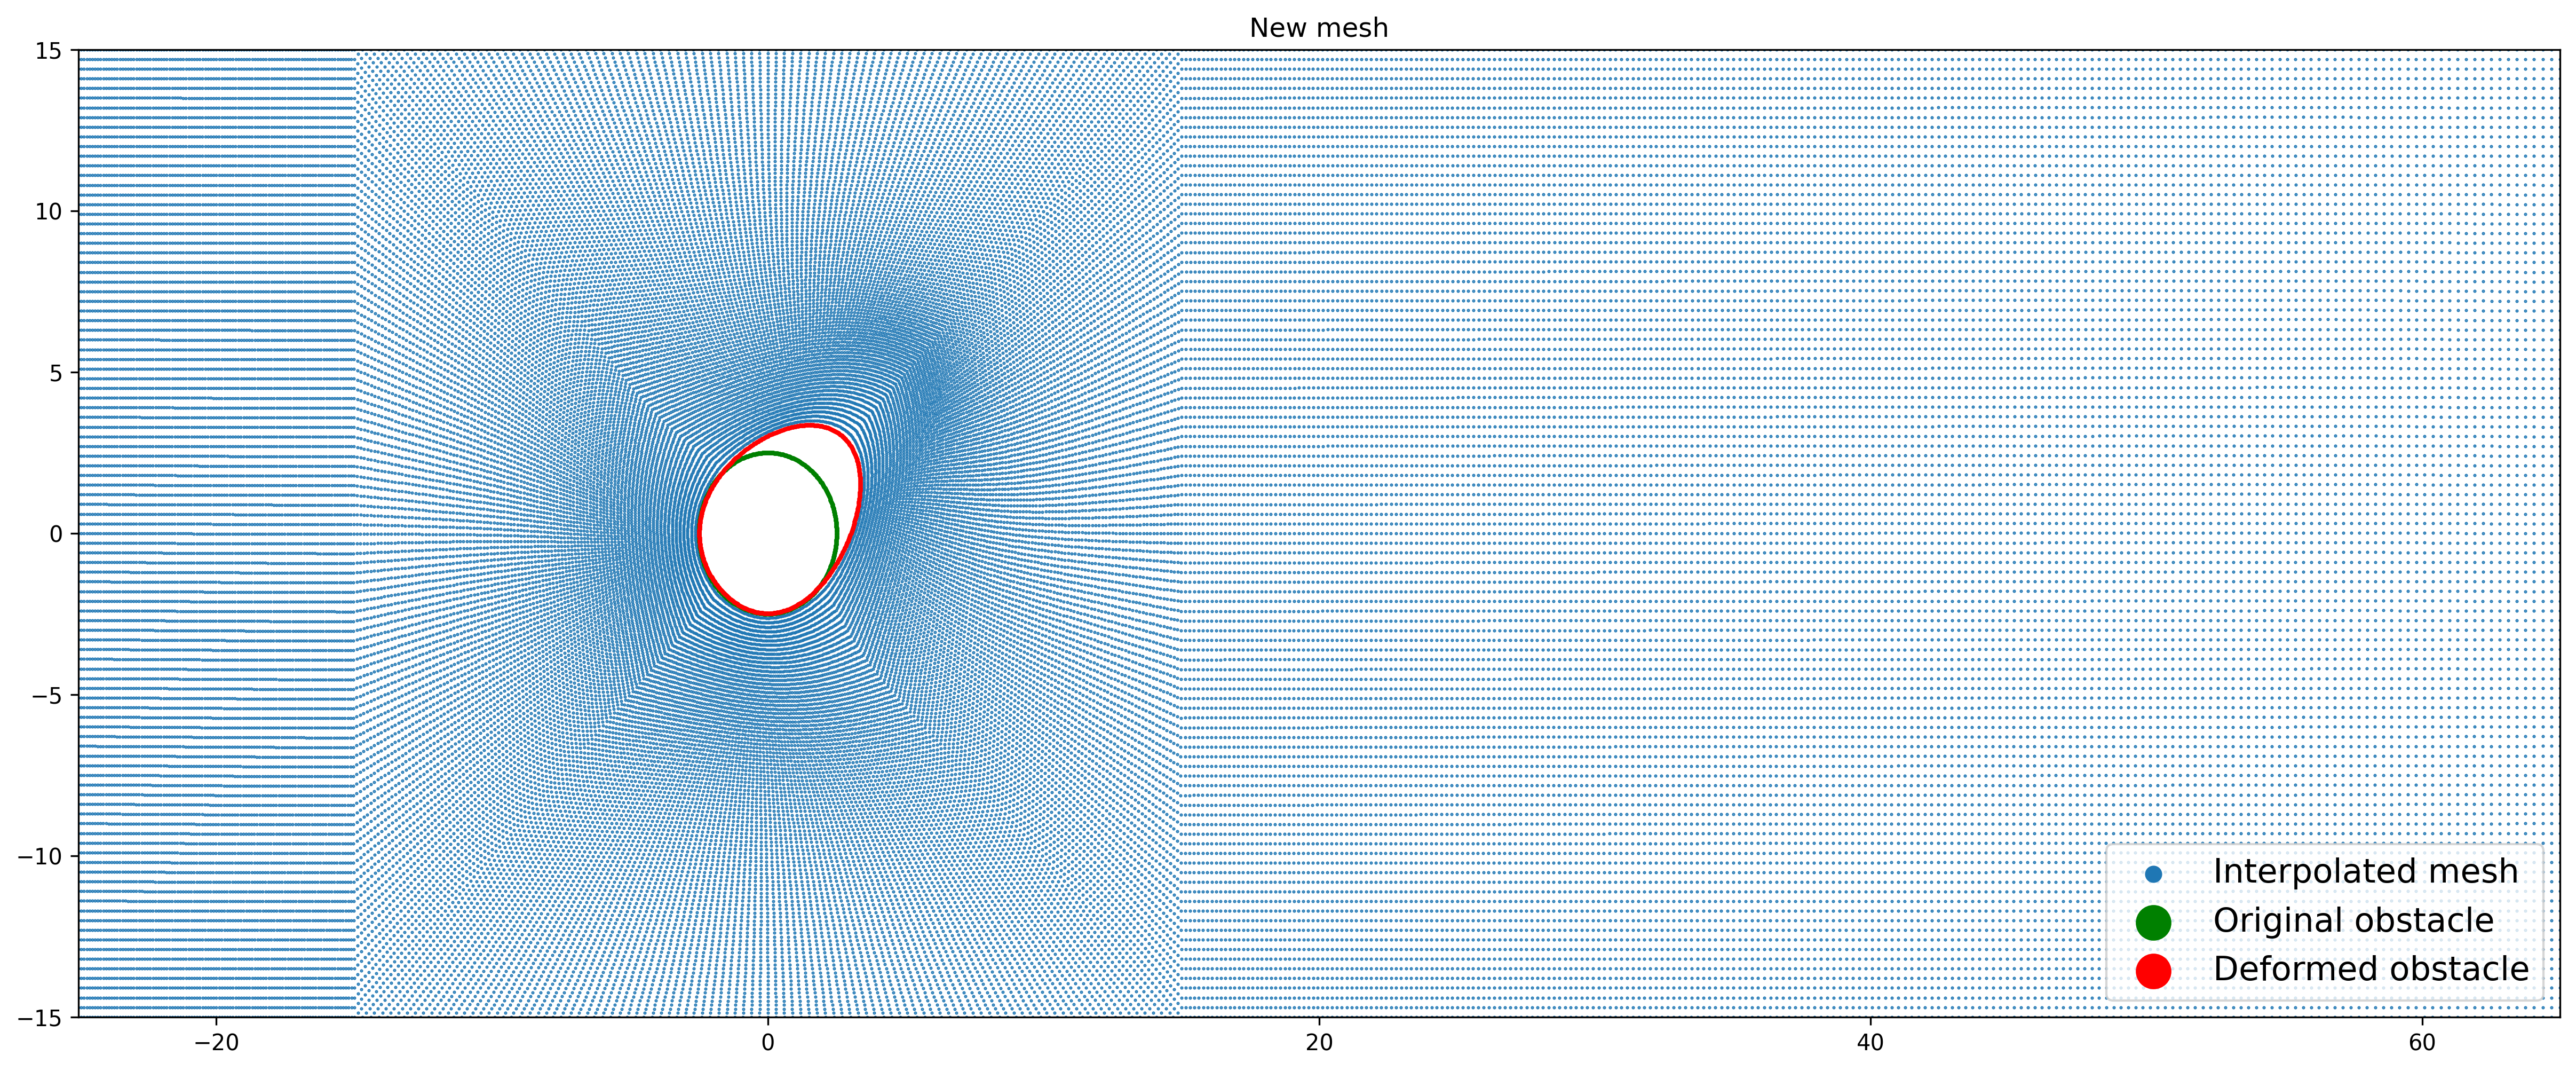

In [15]:
plt.figure(figsize=(20,8), dpi=300)
plt.scatter(*upper_layer(new_mesh_points)[:,:2].T, s=0.2, label='Interpolated mesh')
plt.scatter(*upper_layer(obstacle)[:,:2].T, s=1, color='g', label='Original obstacle')
plt.scatter(*upper_layer(transform(obstacle))[:,:2].T, s=1, color='r', label='Deformed obstacle')

plt.margins(x=0, y=0)
plt.legend(prop={"size":15}, markerscale=15)
plt.title('New mesh')

plt.show()